In [ ]:
# Importation des librairies nécessaires à ce  projet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set(style="darkgrid")
from time import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
# Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


In [ ]:
# Données d'entrainement
# Ajoutons des noms de colonnes aux données
columns = ['age', 'classemetier', 'fnlwgt', 'education', 'education-rang', 'status-marital', 'occupation',
           'relation', 'race','genre', 'gain-surcapital', 'perte-surcapital', 'heure-par-semaine', 'pays-origine', 'salaire']

# Lecture des données d'entrainement
adult_train = pd.read_csv('adult.data', header=None, names=columns, skipinitialspace=True)

# Suppression de la colonne sur le poids fnlwgt non utilisé dans les analyses à suivre
adult_train = adult_train.drop('fnlwgt', axis=1)

# Affichage de lignes et dimensions du jeux de données d'entrainements.
display(adult_train.head())
display(adult_train.shape)

,age,classemetier,education,education-rang,status-marital,occupation,relation,race,genre,gain-surcapital,perte-surcapital,heure-par-semaine,pays-origine,salaire
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


(32561, 14)

In [ ]:
#Lecture des données de test
adult_test = pd.read_csv('adult.test', header=None, skiprows=1, names=columns, skipinitialspace=True)


# Suppression de la colonne sur le poids fnlwgt non utilisé dans les analyses à suivre
adult_test = adult_test.drop('fnlwgt', axis=1)

# Enlever '.' de la colonne salaire
adult_test['salaire'] = adult_test['salaire'].apply(lambda x: '>50K' if x=='>50K.' else '<=50K')

# Affichage de lignes et dimensions du jeux de données d'entrainements.
display(adult_test.head())
display(adult_test.shape)

,age,classemetier,education,education-rang,status-marital,occupation,relation,race,genre,gain-surcapital,perte-surcapital,heure-par-semaine,pays-origine,salaire
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


(16281, 14)

In [ ]:
# Examiner si des valeurs sont manquantes
adult_test.info()

# Vérifier la présence du code de valeurs manquantes et convertir en NaNs
#Object récupère les colonnes dont les types objets sont renseignés comme valeurs. '?' par exemple
object_col = adult_train.select_dtypes(include=object).columns.tolist()
for col in object_col:
    print(adult_train[col].value_counts(dropna=False)/adult_train.shape[0],'\n')

# Convertir '?' en NaNs et supprimer les entrées avec des valeurs NaN
for col in object_col:
    adult_train.loc[adult_train[col]=='?', col] = np.nan
    adult_test.loc[adult_test[col]=='?', col] = np.nan

# Evaluer le taux de données manquantes dans le  dataset.
col_missing_pct = adult_train.isna().sum()/adult_train.shape[0]
col_missing_pct.sort_values(ascending=False)

# Supprimer les entrées avec des données à valeurs manquantes
adult_train = adult_train.dropna(axis=0, how='any')
adult_test = adult_test.dropna(axis=0, how='any')

# Affichage des valeurs pour les jeux de données
print(f"Après suppression des valeurs manquantes :\nTrain : {adult_train.shape[0]} lignes\nTest  : {adult_test.shape[0]} lignes")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                16281 non-null  int64 
 1   classemetier       16281 non-null  object
 2   education          16281 non-null  object
 3   education-rang     16281 non-null  int64 
 4   status-marital     16281 non-null  object
 5   occupation         16281 non-null  object
 6   relation           16281 non-null  object
 7   race               16281 non-null  object
 8   genre              16281 non-null  object
 9   gain-surcapital    16281 non-null  int64 
 10  perte-surcapital   16281 non-null  int64 
 11  heure-par-semaine  16281 non-null  int64 
 12  pays-origine       16281 non-null  object
 13  salaire            16281 non-null  object
dtypes: int64(5), object(9)
memory usage: 1.7+ MB
classemetier
Private             0.697030
Self-emp-not-inc    0.078038
Local-gov         

In [ ]:
print(f"Après suppression des valeurs manquantes :\nTrain : {adult_train.shape[0]} lignes\nTest  : {adult_test.shape[0]} lignes")


Après suppression des valeurs manquantes :
Train : 30162 lignes
Test  : 15060 lignes


In [ ]:
# Combinons les jeux de données
adult_data = pd.concat([adult_train, adult_test])


In [ ]:
# Total du nombre des entrées
n_records = adult_data.shape[0]

In [ ]:
# Nombre des entrées où les individus ont un salaire supérieur à $50,000
n_greater_50k = np.sum(adult_data.salaire=='>50K')

# Nombre des entrées où les individus ont un salaire inférieur à $50,000
n_at_most_50k = np.sum(adult_data.salaire=='<=50K')

# Pourcentage d'individus avec un salaire de plus de $50,000
greater_percentage = round(np.mean(adult_data.salaire=='>50K')*100.00, 2)

# Print the results
print("Total du nombre des entrées: {}".format(n_records))
print("Individus ayant plus de $50,000 de salaire: {}".format(n_greater_50k))
print("Individus ayant au plus $50,000 de salaire : {}".format(n_at_most_50k))
print("Pourcentage d'individus avec un salaire de plus de $50,000: {}%".format(greater_percentage))

Total du nombre des entrées: 45222
Individus ayant plus de $50,000 de salaire: 11208
Individus ayant au plus $50,000 de salaire : 34014
Pourcentage d'individus avec un salaire de plus de $50,000: 24.78%


In [ ]:
num_col = adult_train.dtypes[adult_train.dtypes != 'object'].index

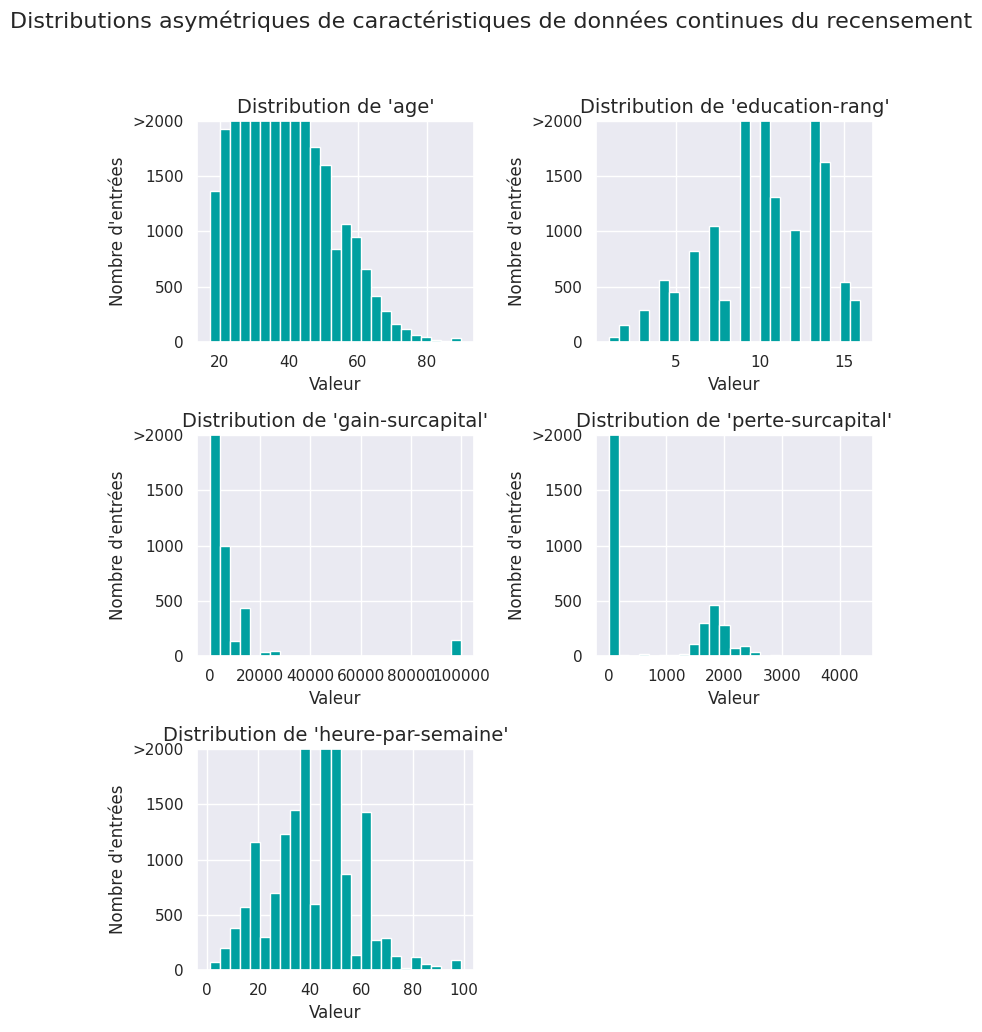

In [ ]:
fig = plt.figure(figsize = (8,10));
for i, feature in enumerate(adult_train[num_col]):
  ax = fig.add_subplot(3, 2, i+1)
  ax.hist(adult_train[feature], bins = 25, color = '#00A0A0')
  ax.set_title("Distribution de '%s'" % (feature), fontsize = 14)
  ax.set_xlabel("Valeur")
  ax.set_ylabel("Nombre d'entrées")
  ax.set_ylim((0, 2000))
  ax.set_yticks([0, 500, 1000, 1500, 2000])
  ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])
fig.suptitle("Distributions asymétriques de caractéristiques de données continues du recensement", fontsize = 16, y = 1.03)
fig.tight_layout()
fig.show()




In [ ]:
# Calcul de l'asymétrie et ordonancer
skew_feats = adult_train[num_col].skew().sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skew_feats})
skewness

,Skew
gain-surcapital,11.902682
perte-surcapital,4.526380
age,0.530228
heure-par-semaine,0.330869
education-rang,-0.305379


In [ ]:
# Scinder les données en entrées(caratéristiques) et sorties (cible)
salaire_brut = adult_train['salaire']
carateristiques_brut = adult_train.drop('salaire', axis=1)

salaire_brut_test = adult_test['salaire']
carateristiques_brut_test = adult_test.drop('salaire', axis=1)

# Log transformation des caractéristiques fortement asymétriques 'gain-surcapital', 'perte-surcapital'.
skewed = ['gain-surcapital', 'perte-surcapital']
features_log_transformed = pd.DataFrame(data=carateristiques_brut)
features_log_transformed[skewed] = carateristiques_brut[skewed].apply(lambda x: np.log(x + 1))

features_log_transformed_test = pd.DataFrame(data=carateristiques_brut_test)
features_log_transformed_test[skewed] = carateristiques_brut_test[skewed].apply(lambda x: np.log(x + 1))

In [ ]:
# Initialiser un scaler, à appliquer aux caratéristiques
scaler = MinMaxScaler() # default=(0, 1)

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[num_col] = scaler.fit_transform(features_log_transformed[num_col])

# Faire la même chose pour les données de tests
features_log_minmax_transform_test = pd.DataFrame(data = features_log_transformed_test)
features_log_minmax_transform_test[num_col] = scaler.transform(features_log_transformed_test[num_col])


# Affichage d'une instance de données mis à l'échelle
display(features_log_minmax_transform.head())

,age,classemetier,education,education-rang,status-marital,occupation,relation,race,genre,gain-surcapital,perte-surcapital,heure-par-semaine,pays-origine
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


In [ ]:
features_log_minmax_transform_test.shape

(15060, 13)

In [ ]:
features_log_minmax_transform.shape

(30162, 13)

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Encodage One-hot des données 'features_log_minmax_transform' avec sklearn.OneHotEncoder

# Liste des données catégorielles
cat_feats = features_log_minmax_transform.dtypes[features_log_minmax_transform.dtypes=='object'].index.tolist()
cat_idx = [features_log_minmax_transform.columns.get_loc(col) for col in cat_feats]

labelencoder_feats = []
encoded_cat_features = []
# Encodage des labels.
for i, col in enumerate(cat_feats):
    labelencoder_feats = np.hstack([labelencoder_feats, LabelEncoder()])
    if i == 0:
        encoded_cat_features = labelencoder_feats[i].fit_transform(features_log_minmax_transform.loc[:,col])
    else:
        encoded_cat_features = np.vstack([encoded_cat_features, labelencoder_feats[i].fit_transform(features_log_minmax_transform.loc[:,col])])

# Création de  l'encodeur.
encoder = OneHotEncoder(handle_unknown='error', sparse_output=False)

# Fit et transform de l'encoder sur les caractéristiques numériques
encoded_cat_feats = encoder.fit_transform(np.array(encoded_cat_features).T)

# Extractions des noms des caractéristiques à encoder
cat_col_name = features_log_minmax_transform.columns[cat_idx].tolist()
encoded_cat_feats_name = encoder.get_feature_names_out(cat_col_name)

# Génération du data frame OHE pour concaténation avec le dataframe numérique par la suite.
encoded_cat_feats_df = pd.DataFrame(encoded_cat_feats, columns=encoded_cat_feats_name)
encoded_cat_feats_df.head()


In [ ]:
# Encodage des labels.
encoded_cat_features_tests = [labelencoder_feats[i].transform(features_log_minmax_transform_test.loc[:,col])for i, col in enumerate(cat_feats)]

# Fit et transform de l'encoder sur les caractéristiques numériques
encoded_cat_feats_test = encoder.transform(np.array(encoded_cat_features_tests).T)

# Extractions des noms des caractéristiques à encoder
cat_col_name = features_log_minmax_transform.columns.values[cat_idx].tolist()
encoded_cat_feats_name = encoder.get_feature_names_out(cat_col_name)


# Générer le dataframe OHE pour concaténation avec le dataframe numérique par la suite.
encoded_cat_feats_df_test = pd.DataFrame(encoded_cat_feats_test, columns=encoded_cat_feats_name)
encoded_cat_feats_df_test.head()



,classemetier_0,classemetier_1,classemetier_2,classemetier_3,classemetier_4,classemetier_5,classemetier_6,education_0,education_1,education_2,...,pays-origine_31,pays-origine_32,pays-origine_33,pays-origine_34,pays-origine_35,pays-origine_36,pays-origine_37,pays-origine_38,pays-origine_39,pays-origine_40
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# Extraction du dataframe avec uniquement les données numériques.
num_feats_df = features_log_minmax_transform[num_col].reset_index()

# Concaténation des données numériques avec les données catégorielles encodées.
X_train = pd.merge(num_feats_df, encoded_cat_feats_df, left_index=True, right_index=True).drop('index', axis=1)

# Enconder les 'salaire_brut' en valeurs numériques
y_train = salaire_brut.apply(lambda x: 1 if x == '>50K' else 0)

print("{} caractéristiques au total après l'encodage one-hot.".format(len(X_train.columns)))

# Affichage de quelques ligne du dataframe préttraité.
X_train.head()

103 caractéristiques au total après l'encodage one-hot.


,age,education-rang,gain-surcapital,perte-surcapital,heure-par-semaine,classemetier_0,classemetier_1,classemetier_2,classemetier_3,classemetier_4,...,pays-origine_31,pays-origine_32,pays-origine_33,pays-origine_34,pays-origine_35,pays-origine_36,pays-origine_37,pays-origine_38,pays-origine_39,pays-origine_40
0,0.301370,0.800000,0.667492,0.0,0.397959,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.452055,0.800000,0.000000,0.0,0.122449,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.287671,0.533333,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.493151,0.400000,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.150685,0.800000,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Extract the dataframe with only numerical features
num_feats_df_test = features_log_minmax_transform_test[num_col].reset_index()

# Concatenate numerical and encoded categorical features together
X_test = pd.merge(num_feats_df_test, encoded_cat_feats_df_test, left_index=True, right_index=True)\
            .drop('index', axis=1)

# Encode the 'income_raw' to numerical values
y_test = salaire_brut_test.apply(lambda x: 1 if x == '>50K' else 0)

print("{} caractéristiques au total après l'encodage one-hot.".format(len(X_test.columns)))

# Display several rows of processed dataframe
X_test.head()


103 caractéristiques au total après l'encodage one-hot.


,age,education-rang,gain-surcapital,perte-surcapital,heure-par-semaine,classemetier_0,classemetier_1,classemetier_2,classemetier_3,classemetier_4,...,pays-origine_31,pays-origine_32,pays-origine_33,pays-origine_34,pays-origine_35,pays-origine_36,pays-origine_37,pays-origine_38,pays-origine_39,pays-origine_40
0,0.109589,0.400000,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.287671,0.533333,0.000000,0.0,0.500000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.150685,0.733333,0.000000,0.0,0.397959,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.369863,0.600000,0.777174,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.232877,0.333333,0.000000,0.0,0.295918,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# Calcule de l'accuracy, la précision et le recall
accuracy = np.sum(y_train)/ y_train.count()
recall = np.sum(y_train) / np.sum(y_train)
precision = np.sum(y_train) / y_train.count()

print(recall)
print(accuracy)
print(precision)

# Calcule du F-score avec beta = 0.5 et avec les valeurs des précision et recall.
fscore = (1 + 0.5*0.5)* precision* recall/ (0.5*0.5*precision + recall)
print(fscore)

1.0
0.24892248524633645
0.24892248524633645
0.2929242485720528


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
# Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [ ]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test):
    '''
    inputs:
       - learner: l'algorithme d'apprentissage à entrainer et à prédire
       - sample_size: taille des données (nombre d'instances) à échantilloner des données d'apprentissage
       - X_train: caratéristiques pour les données d'apprentissage
       - y_train: salaire données d'apprentissage
       - X_test: caratéristiques pour les données de tests
       - y_test: salaire données de tests
    '''

    results = {}

    # Adapter l'algorithme d'apprentissage sur des tranches de données avec la variable 'sample_size'
    start = time() # Temps de démarrage de l'apprentissage
    learner =  learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Temps de fin

    # Calcule de la durée d'apprentissage
    results['train_time'] = end - start

    # Effectuer les préduction sur les données de test (X_test),
    # et sur les premières 300 instances d'entrainement (X_train) avec la fonction .predict()
    start = time() # Temps de démarrage
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Temps de fin

    # Calcule de la durée de prediction
    results['pred_time'] = end - start

    # Calcule de l'accuracy  sur les 300 premières instances d'entrainement y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)

    # Calcule de l'accuracy  sur les données de tests avec la fonction accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)

    # Calcule du F-score sur les 300 premières instances d'entrainement avec fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, average = 'binary', beta = 0.5)

    # Calcule du F-score sur les données de tests y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, average = 'binary', beta = 0.5)

    # Avancements
    print("{} entrainé sur {} instances.".format(learner.__class__.__name__, sample_size))

    # Retourner les resultats
    return results

In [ ]:
# Initialiser les trois modèles
clf_A = LogisticRegression(random_state = 42)
clf_B = RandomForestClassifier(random_state=42)
clf_C = AdaBoostClassifier(random_state = 42)
clf_D = SVC(random_state = 42)

# Calculer le nombre d'instances pour 1%, 10%, et 100% des données d'entrainement
samples_100 = int(len(X_train))
samples_10 = int(len(X_train) / 10)
samples_1 = int(len(X_train) / 100)

# Récupérer les résulats pour chaque algorithme d'apprentissage
results = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

LogisticRegression entrainé sur 301 instances.
LogisticRegression entrainé sur 3016 instances.
LogisticRegression entrainé sur 30162 instances.
RandomForestClassifier entrainé sur 301 instances.
RandomForestClassifier entrainé sur 3016 instances.
RandomForestClassifier entrainé sur 30162 instances.
AdaBoostClassifier entrainé sur 301 instances.
AdaBoostClassifier entrainé sur 3016 instances.
AdaBoostClassifier entrainé sur 30162 instances.
SVC entrainé sur 301 instances.
SVC entrainé sur 3016 instances.
SVC entrainé sur 30162 instances.


In [ ]:
for i in results.items():
    print (i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

LogisticRegression


,1%,10%,100%
train_time,0.036157,0.100003,2.034108
pred_time,0.024527,0.018201,0.024709
acc_train,0.843333,0.826667,0.823333
acc_test,0.824436,0.840106,0.841169
f_train,0.688525,0.644699,0.637982
f_test,0.648521,0.681013,0.685099


RandomForestClassifier


,1%,10%,100%
train_time,0.504905,0.506555,6.315283
pred_time,0.165421,0.299791,0.556866
acc_train,1.000000,0.990000,0.980000
acc_test,0.827158,0.835193,0.840040
f_train,1.000000,0.975610,0.951743
f_test,0.657834,0.669010,0.679412


AdaBoostClassifier


,1%,10%,100%
train_time,0.124499,0.294229,1.712335
pred_time,0.206634,0.202447,0.210225
acc_train,0.873333,0.826667,0.840000
acc_test,0.842032,0.839641,0.848539
f_train,0.760518,0.643836,0.674487
f_test,0.696781,0.678419,0.703843


SVC


,1%,10%,100%
train_time,0.008968,0.357979,72.168897
pred_time,0.355747,2.575752,29.276973
acc_train,0.863333,0.833333,0.833333
acc_test,0.809230,0.835525,0.842098
f_train,0.777778,0.661538,0.659026
f_test,0.602026,0.673629,0.688443


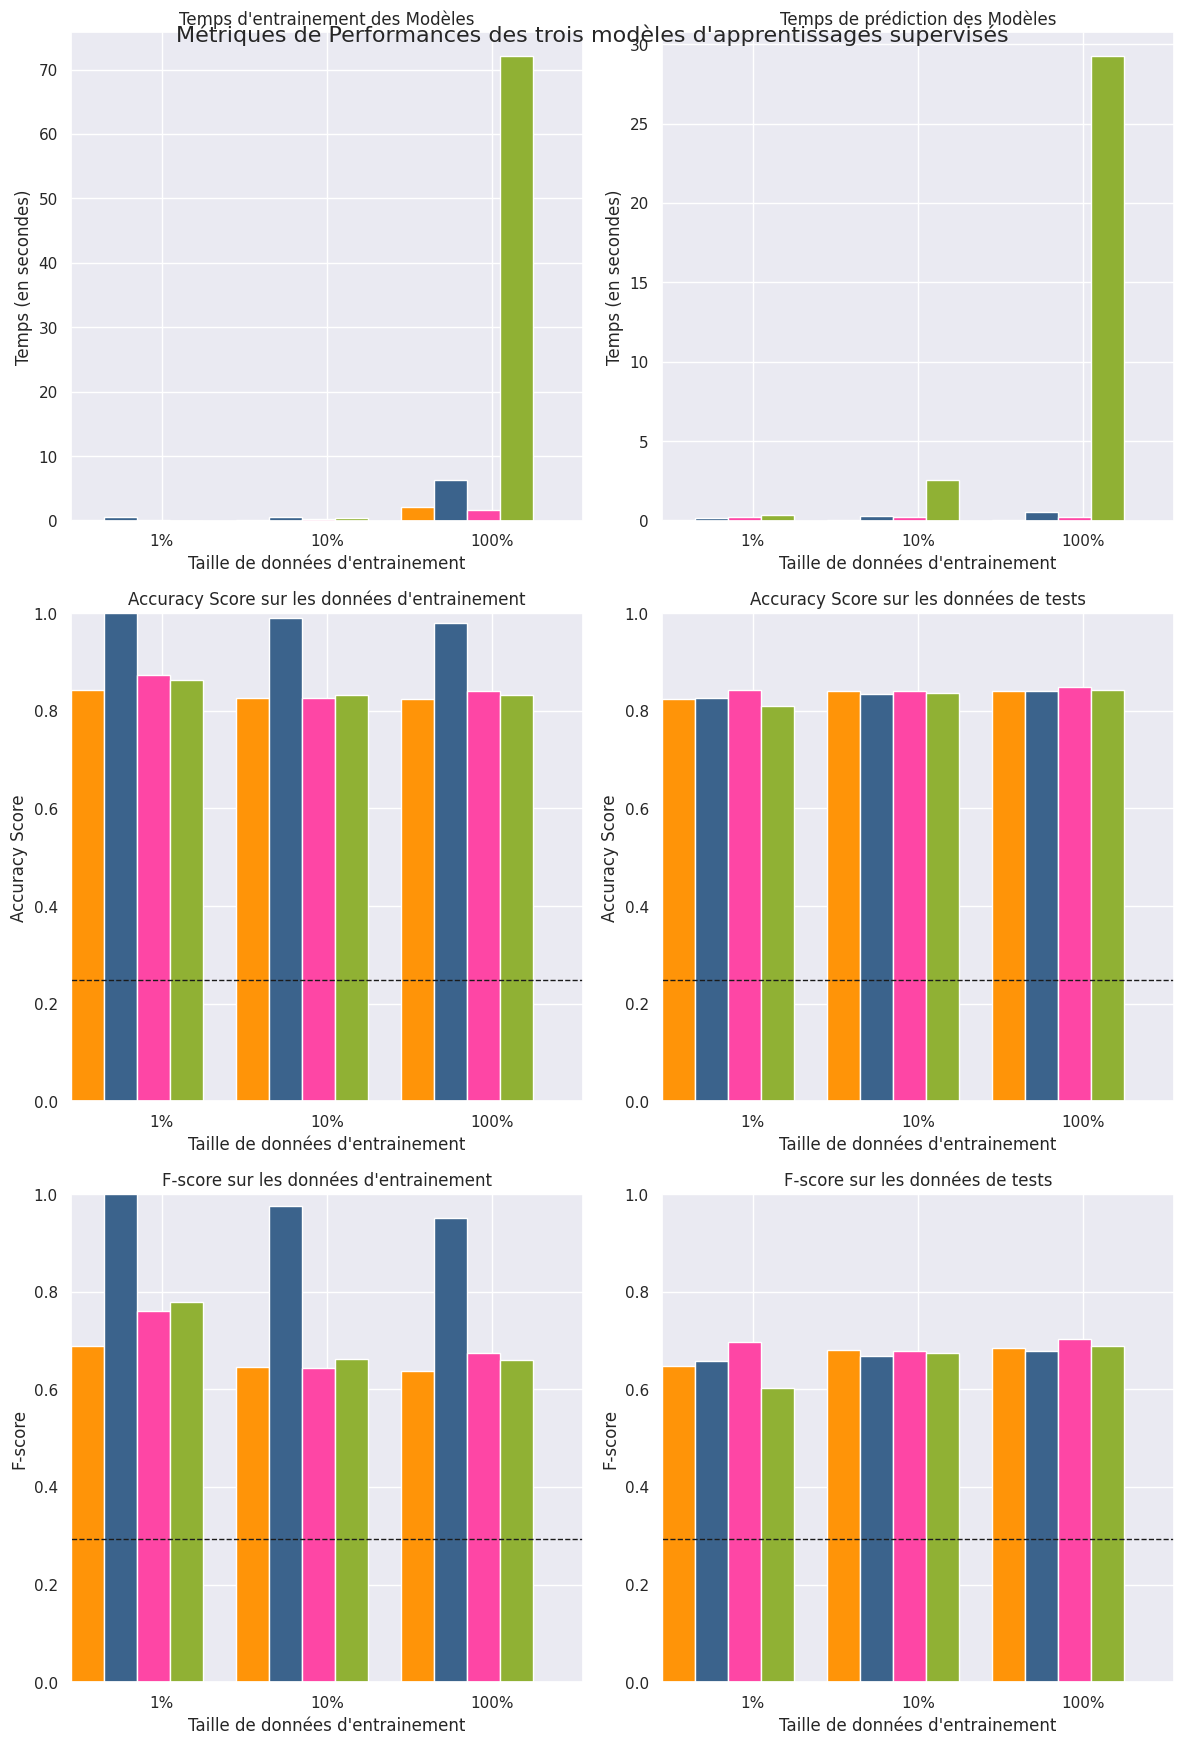

In [ ]:
# Visualisation des métriques pour les différents modèles entrainés.

# Creation de la figure
fig, ax = plt.subplots(3, 2, figsize = (12,18))

# Constantes
bar_width = 0.2
colors =  ['#ff9408', '#3b638c', '#fe46a5', '#90b134']

# Boucle de tracé des quatres panneaux des données
for k, learner in enumerate(results.keys()):
    for j, metric in enumerate(['train_time','pred_time', 'acc_train', 'acc_test', 'f_train', 'f_test']):
        for i in np.arange(3):

            # Code des tracés
            ax[j//2, j%2].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
            ax[j//2, j%2].set_xticks([0.45, 1.45, 2.45])
            ax[j//2, j%2].set_xticklabels(["1%", "10%", "100%"])
            ax[j//2, j%2].set_xlabel("Taille de données d'entrainement")
            ax[j//2, j%2].set_xlim((-0.1, 3.0))

# Ajout des y-labels
ax[0, 0].set_ylabel("Temps (en secondes)")
ax[0, 1].set_ylabel("Temps (en secondes)" )
ax[1, 0].set_ylabel("Accuracy Score")
ax[1, 1].set_ylabel("Accuracy Score")
ax[2, 0].set_ylabel("F-score")
ax[2, 1].set_ylabel("F-score")

# Ajout des titres
ax[0, 0].set_title("Temps d'entrainement des Modèles")
ax[0, 1].set_title("Temps de prédiction des Modèles")
ax[1, 0].set_title("Accuracy Score sur les données d'entrainement")
ax[1, 1].set_title("Accuracy Score sur les données de tests")
ax[2, 0].set_title("F-score sur les données d'entrainement")
ax[2, 1].set_title("F-score sur les données de tests")

# Ajout des lignes horizontales pour les predictions naives
ax[1, 0].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
ax[2, 0].axhline(y = fscore, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
ax[2, 1].axhline(y = fscore, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')

# Définition des y-limits pour les scores
ax[1, 0].set_ylim((0, 1))
ax[1, 1].set_ylim((0, 1))
ax[2, 0].set_ylim((0, 1))
ax[2, 1].set_ylim((0, 1))


plt.suptitle("Métriques de Performances des trois modèles d'apprentissages supervisés", fontsize = 16, y = 0.96)

fig.tight_layout()
fig.show()

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import GridSearchCV
import numpy as np
from time import time

# Initialiser le classifieur
clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42)

# Créer la liste de paramètres
parameters = {
    'n_estimators': [50, 75, 100, 200],
    'learning_rate': [0.05, 0.1, 0.3, 1],
    'estimator__min_samples_split': np.arange(2, 8, 2),
    'estimator__max_depth': np.arange(1, 4, 1)
}

# Réaliser un fbeta_score scoring
scorer = make_scorer(fbeta_score, beta=0.5)

# Recherche maillée
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

start = time()
# Apprentissage
grid_fit = grid_obj.fit(X_train, y_train)

# Meilleur estimateur
best_clf = grid_fit.best_estimator_

# Prédictions
predictions = clf.fit(X_train, y_train).predict(X_test)
best_predictions = best_clf.predict(X_test)
end = time()


In [ ]:
print("--- Temps d'exécution: %s mins ---" % np.round(((end - start)/60),2))

--- Temps d'exécution: 63.01 mins ---


In [ ]:
print(best_clf)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=np.int64(3),
                                                    min_samples_split=np.int64(6)),
                   learning_rate=1, n_estimators=200, random_state=42)


In [ ]:
train_predict(best_clf, len(X_train), X_train, y_train, X_test, y_test)

AdaBoostClassifier entrainé sur 30162 instances.


{'train_time': 15.308126449584961,
 'pred_time': 0.7664694786071777,
 'acc_train': 0.8633333333333333,
 'acc_test': 0.8612217795484728,
 'f_train': 0.7246376811594203,
 'f_test': 0.7299068855672629}

In [ ]:
best_clf.feature_importances_

array([1.68959357e-01, 7.66479260e-02, 1.94698362e-01, 1.48888543e-01,
       5.03251708e-02, 3.47206257e-03, 6.18709138e-03, 1.13927358e-03,
       7.88705767e-04, 7.36793894e-03, 1.09806064e-03, 0.00000000e+00,
       7.88137755e-04, 0.00000000e+00, 3.33563241e-03, 0.00000000e+00,
       0.00000000e+00, 6.69037970e-03, 0.00000000e+00, 1.13228630e-03,
       5.82217407e-04, 7.80929619e-03, 3.16373764e-04, 6.46364308e-03,
       8.53552536e-04, 2.89765023e-04, 2.57987986e-15, 6.01300910e-03,
       2.31428710e-03, 4.64437646e-02, 1.00084364e-01, 0.00000000e+00,
       2.93352652e-03, 5.94093880e-16, 4.10172739e-03, 1.81909684e-03,
       0.00000000e+00, 1.20212683e-17, 1.12168339e-02, 8.04083237e-03,
       3.94585467e-03, 4.10413469e-03, 5.51067477e-03, 1.83274282e-02,
       3.85474428e-03, 4.58674386e-03, 4.53773283e-03, 7.76042477e-03,
       0.00000000e+00, 2.69381529e-03, 1.08137569e-02, 3.90319809e-04,
       1.80766451e-02, 3.05825006e-04, 9.17867800e-03, 1.16807219e-03,
      

In [ ]:
feats = pd.DataFrame(
    index=X_train.columns, data=best_clf.feature_importances_, columns=['Importance'])

In [ ]:
imp_feats = feats[feats['Importance'] > 0]

<Axes: >

<Figure size 1200x800 with 0 Axes>

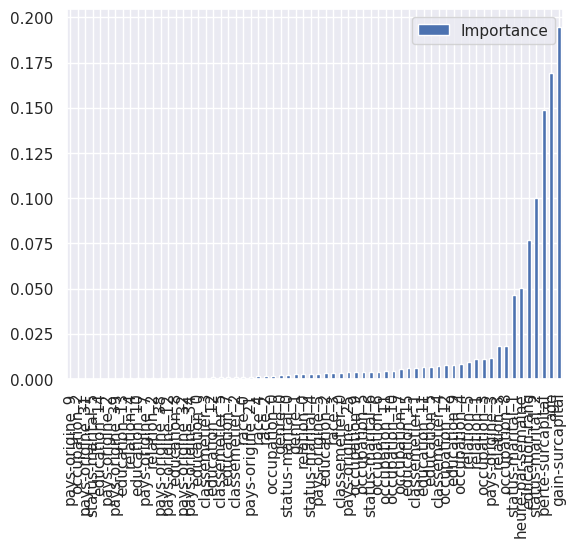

In [ ]:
plt.figure(figsize=(12, 8))
imp_feats.sort_values(by='Importance').plot(kind='bar')

In [ ]:
# Report the before-and-afterscores
print("Modèle non optimisé\n------")
print("L'Accuracy sur les données de tests: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score sur les données de test: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\n Modèle optimizé \n------")
print("Accuracy finale sur les données de tests: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score finale sur les données de tests: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Modèle non optimisé
------
L'Accuracy sur les données de tests: 0.8265
F-score sur les données de test: 0.6477

 Modèle optimizé 
------
Accuracy finale sur les données de tests: 0.8612
F-score finale sur les données de tests: 0.7299


In [ ]:
clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state = 42, max_depth=3, min_samples_split=6),\
                         learning_rate=0.1, n_estimators=200, random_state=42)

clf = clf.fit(X_train, y_train)

In [ ]:
predictions = clf.predict(X_test)

In [ ]:
print("L'Accuracy sur les données de tests: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score sur les données de test: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))

L'Accuracy sur les données de tests: 0.8533
F-score sur les données de test: 0.7236


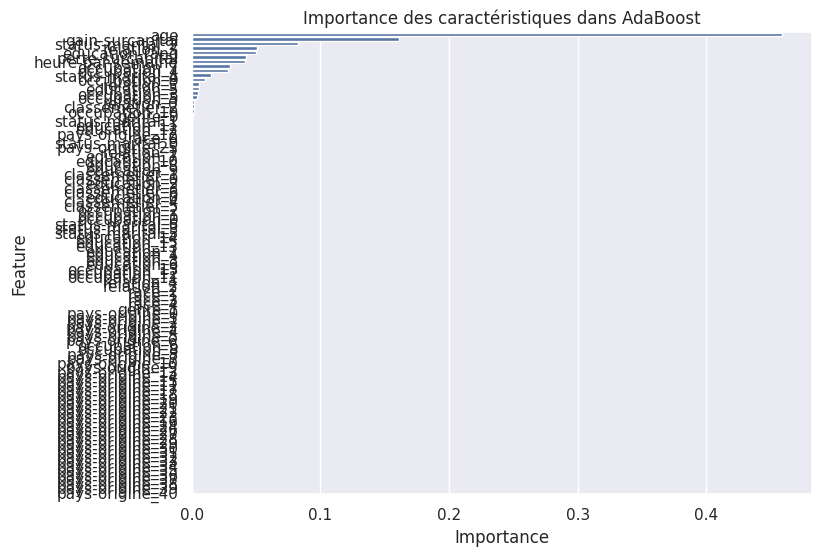

In [ ]:
clf.fit(X_train, y_train)

# Accéder aux importances des caractéristiques de chaque arbre de décision dans l'ensemble
importances = np.zeros(X_train.shape[1])
for estimator in clf.estimators_:
    importances += estimator.feature_importances_

# Moyenne des importances pour chaque caractéristique
importances /= len(clf.estimators_)

# Créer un DataFrame pour afficher l'importance des caractéristiques
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else ['Feature 1', 'Feature 2', 'Feature 3']  # Remplace par tes vraies caractéristiques
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Trier les caractéristiques par ordre d'importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Affichage
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importance des caractéristiques dans AdaBoost')
plt.show()